In [2]:
import csv
import numpy as np
import os
import scipy.stats
import pandas as pd
import sqlite3 as sql
%matplotlib inline

# Titanic Data Analysis
## Questions to investigate:

   How accurate was titanic the movie?
   Were women and children more likely to survive?
   Were people in the lower class less likely to survive?
    

## Loading the Data
### First I am loading the data into a Pandas Data frame.

In [3]:
cwd = os.getcwd()
data_set = os.path.join(cwd,"titanic.db")
conn = sql.connect(data_set)
df = pd.read_sql("select * from titanic;", conn)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
index          891 non-null int64
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(6), object(5)
memory usage: 90.6+ KB


## Looking at the questions which I hope to answer, I see some of the relevant features of the data set are Age, Sex, nd Pclass.

### I will test if there is a significant differents between the survival of males vs the survival of females in the titanic. Formally my hypthosis will be as follows

H<sub>0</sub>: There is no statistical difference in the survival rate of males vs the survival rate of females.

H<sub>1</sub>: There is a statistical difference in the survival rate of males vs the survival rate of females.

[<matplotlib.text.Text at 0x114145a10>, <matplotlib.text.Text at 0x114160690>]

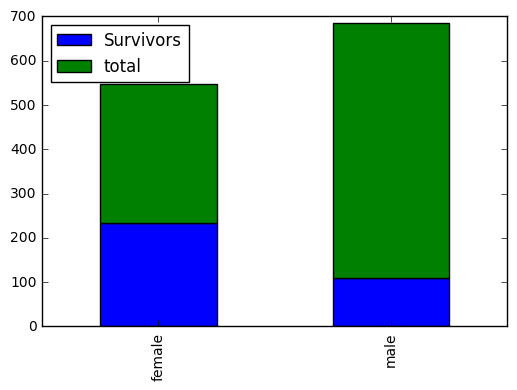

In [3]:
genderDF = pd.read_sql("""
    select
        Sex,
        sum(Survived) as Survivors,
        count(Survived) as total
    from titanic
    group by Sex;
    """, conn)


ax = genderDF.plot(kind="bar", stacked= True)
ax.set_xticklabels(genderDF.Sex)

This graph shows that, while there were fewer females than males, a greater number of females survived than males. I will investigate whether this difference is statistically significant below.

In [4]:
malesDF = pd.read_sql("""
    select
        Survived
    from titanic
    where 
        Sex = 'male';
    """, conn)
femalesDF = pd.read_sql("""
    select
        Survived
    from titanic
    where 
        Sex = 'female';
    """, conn)
scipy.stats.ttest_ind(malesDF,femalesDF)

Ttest_indResult(statistic=array([-19.29781655]), pvalue=array([  1.40606613e-69]))

At the 99% confidence level, I must reject H<sub>0</sub> and Accept H<sub>a</sub> that there is a statistically significant difference in survival rates of males vs females.

### I will test if there is a significant differents between the upper class and other passengers. Formally my hypthosis will be as follows

H<sub>0</sub>: There is no statistical difference in the survival rate of upper class vs others.

H<sub>1</sub>: There is a statistical difference in the survival rate of upper class vs others.

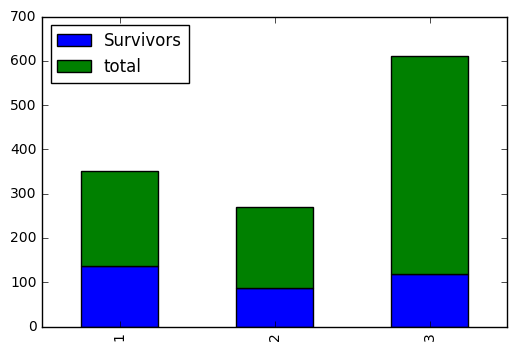

In [7]:
PclassDF = pd.read_sql("""
    select
        Pclass,
        sum(Survived) as Survivors,
        count(Survived) as total
    from titanic
    group by Pclass;
    """, conn)


ax = PclassDF[['Survivors', 'total']].plot(kind="bar", stacked= True)
ax.set_xticklabels(PclassDF.Pclass)

While third class passengers(which is a proxy for the patient's social standing) have a far greater total than 2nd or 1st class passengers, the number of survivors is roughly the same. I will test if this difference is statistically significant.

In [56]:
lower_class = pd.read_sql("""
    select
        Survived
    from titanic
    where 
        Pclass = 3;
    """, conn)
middle_class = pd.read_sql("""
    select
        Survived
    from titanic
    where 
        Pclass = 2;
    """, conn)
upper_class = pd.read_sql("""
    select
        Survived
    from titanic
    where 
        Pclass = 1;
    """, conn)
print upper_class.describe()
print middle_class.describe()
print lower_class.describe()
nonlower = middle_class.append(upper_class)
scipy.stats.ttest_ind(nonlower,lower_class)

         Survived
count  216.000000
mean     0.629630
std      0.484026
min      0.000000
25%      0.000000
50%      1.000000
75%      1.000000
max      1.000000
         Survived
count  184.000000
mean     0.472826
std      0.500623
min      0.000000
25%      0.000000
50%      0.000000
75%      1.000000
max      1.000000
         Survived
count  491.000000
mean     0.242363
std      0.428949
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max      1.000000


Ttest_indResult(statistic=array([ 10.15172889]), pvalue=array([  5.51028100e-23]))

At the 99% confidence level, I must reject H<sub>0</sub> and Accept H<sub>a</sub> that there is a statistically significant difference in survival rates

[<matplotlib.text.Text at 0x1152c6bd0>, <matplotlib.text.Text at 0x115921dd0>]

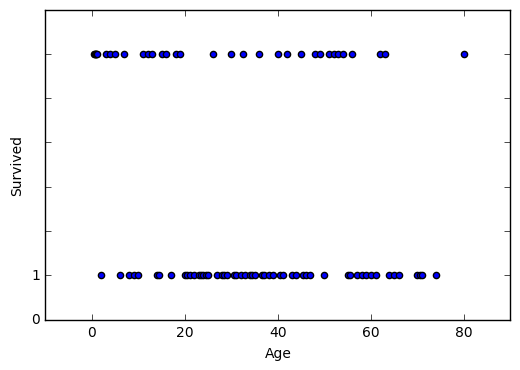

In [9]:
AgeDF = pd.read_sql("""
    select
        Age,
        Survived
    from titanic
    group by Age;
    """, conn)


ax = AgeDF.plot(kind="scatter", x="Age", y="Survived")
ax.set_yticklabels([0,1])

It appears that the age of the surviving passengers are skewed towards the younger half. I will test to see if there is a statistical difference.

### I will test if there is a significant differents between the survival of children vs adults. Formally my hypthosis will be as follows

H<sub>0</sub>: There is no statistical difference in the survival rate of passengers under the age of 16.

H<sub>1</sub>: There is a statistical difference in the survival rate of passengers 16 years or older

In [11]:
adultDF = pd.read_sql("""
    select
        Survived
    from titanic
    where 
        Age is not null
        and Age >= 16;
    """, conn)

childDF = pd.read_sql("""
    select
        Survived
    from titanic
    where 
        Age is not null
        and Age <16;
    """, conn)
childDF

scipy.stats.ttest_ind(adultDF,childDF)

Ttest_indResult(statistic=array([-3.66373042]), pvalue=array([ 0.00026702]))

At the 99% confidence level, I must reject H<sub>0</sub> and Accept H<sub>a</sub> that there is a statistically significant difference in survival rates

# Conclusion.

In conclusion, I have found that the scenes depicted in the movie is consistent with the data. Age, gender, and class all seemed to have a statistically significant relationship with the survival rate of passengers on teh titanic.